## Lab: Cart Pole Demo 2 using OpenAI gym
## Policy Gradient

### University of Virginia
### Reinforcement Learning
#### Last updated: March 4, 2024

---


#### Instructions:  

Carefully read the notes below and run the provided code. Answer each question clearly and show all results.

#### TOTAL POINTS: 12

---

### First a Refresh

Let's briefly review the content from Demo 1: Basics and Simple Policy

We revisit the CartPole problem.

We will work with the fork [gymnasium](https://gymnasium.farama.org/) which maintains OpenAI gym.  

The *simple policy* didn't perform very well: the average reward was about 42.

We want to see if we can do better using a Policy Gradient algorithm.

### Setup and First Steps

In [5]:
! pip install gymnasium

In [6]:
! pip install renderlab

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import renderlab as rl

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Load the environment

In [8]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
state = env.reset(seed=314)

Given the state, we take an action. The next state comes from the environment, which is encoded in `gym`.

Components:   
[0]: cart horizontal position (0.0 = center)  
[1]: velocity (positive means right)  
[2]: angle of the pole (0.0 = vertical)  
[3]: pole's angular velocity (positive means clockwise)

In [10]:
state

(array([0.04225422, 0.02126478, 0.02520455, 0.00700802], dtype=float32), {})

In [11]:
# state space number of components
env.observation_space.shape[0]

4

The action space consists of two options:

[0]: move cart left   
[1]: move cart right

In [12]:
env.action_space

Discrete(2)

Let's take an action, draw a sample and look at the results.

In [13]:
# move right
action = 1

# take a step and get next state, reward from environment
state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print('state', state)
print('reward', reward)
print('done', done)
print('info', info)

state [ 0.04267951  0.21601637  0.02534471 -0.27761722]
reward 1.0
done False
info {}


**Reward and Episode**  

For each time step that the cart keeps the pole balanced, it earns reward 1.

If the pole tilts too much or if the cart moves off screen, `reward=0` and `done=True` (the episode will end).

When the episode ends, a new episode may begin. The process learns cumulatively from each episode.

**Simple policy**:  

When the pole leans left (negative angle), move left. When the pole leans right (positive angle), move right.

Run many episodes and visualize their reward distribution.

In [14]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

num_episodes = 1000
num_steps = 1000
rewards = []

for episode in range(num_episodes):
    ep_reward = 0
    state = env.reset()[0]
    for step in range(num_steps):
        #print(state)
        action = simple_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        if done:
            break

    rewards.append(ep_reward)

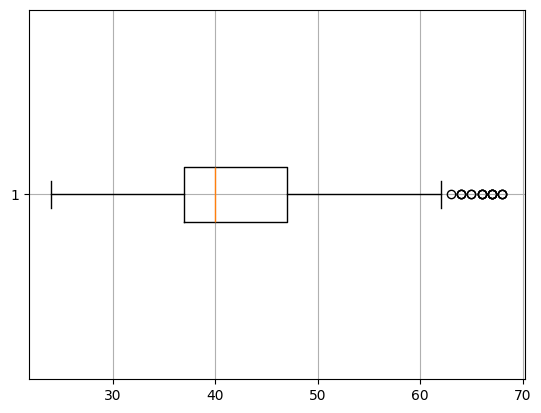

In [15]:
plt.boxplot(rewards, vert=False)
plt.grid()
plt.show()

In [17]:
print('mean reward:', np.mean(rewards))

mean reward: 41.993


### Neural Network Policy

Now we try a more sophisticated policy: let's use a neural network.

The network will take **state as input**. The output node will contain the probability of the actions.

Since there are two actions (left, right), we require one output node.  
Node will output probability of right (so prob of left is implied).

For simplicity, we will use one hidden layer.

Number of nodes in hidden layer is a hyperparameter.

---


#### 1) **Define a neural network model for the policy.**

**(POINTS: 1)**  
It should have appropriate dimensions for the input and output layer. Print a summary of the model that shows the output shape for each layer.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the number of nodes in the hidden layer as a hyperparameter
HIDDEN_LAYER_SIZE = 32

# Define the neural network model using PyTorch
class PolicyNetwork(nn.Module):
    def __init__(self, observation_space_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(observation_space_size, HIDDEN_LAYER_SIZE) # Input layer to hidden layer
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(HIDDEN_LAYER_SIZE, 1) # Hidden layer to output layer
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for probability of action 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        action_prob = self.sigmoid(x)
        return action_prob

# Instantiate the model
model = PolicyNetwork(env.observation_space.shape[0])

# Print the model
print(model)

PolicyNetwork(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### 2) Is **REINFORCE** a Monte Carlo method? Explain your answer.

**(POINTS: 1)**

Yes, REINFORCE is a Monte Carlo method. It collects the rewards from the entire episode before calculating the discounted return. This return is then used to update the policy parameters using gradient ascent.



#### 3) **Training and Evaluating the Policy Model.**

Define functions to train and evaluate the model. Your work should include the steps below among others. Note that subtasks are numbered [1], [2], etc. and are worth one point each.

- **(POINTS: 2)** Write a function `play_single_step` to evolve the system one step. It should also compute the gradient of the loss function. Test that it works properly and print the next state.  

- **(POINTS: 2)** Write a function that runs multiple episodes, calling the `play_single_step` function. It should also compute and store the reward and gradient for each time step of each episode. Test that it works properly and print the rewards from running two episodes each with five time steps.
- **(POINTS: 3)** Define and run a training loop using the REINFORCE algorithm that [1] runs multiple episodes, [2] computes discounted rewards, and [3] updates the parameters with gradient ascent. Run a sufficient number of episodes and time steps to see an average reward of at least 75 in the `evaluate` step that follows. Show evidence that the training loop is working, such as printing the total discounted rewards per episode.
- **(POINTS: 3)** Now that the model is trained, you can use it as the policy and evaluate performance. Write code that [1] applies the model as the policy, [2] runs 1000 episodes and [3] computes the minimum reward, average reward, and maximum reward across the episodes. Discuss how the average reward from REINFORCE compares to the average reward from the simple policy from Cart Pole lab 1.

---

In [ ]:
# play_single_step


In [ ]:
# play_multiple_steps


In [ ]:
# training loop


In [ ]:
# evaluate policy performance
